In [84]:
import sys
sys.path.append('..')
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.getcwd()
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['U','G','R','I','Z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [85]:
# Original                                                                                      Fiducial Wavelength
M51_B       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_B_kab2003.fits')         #4400 Å
M51_V       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_V_kab2003.fits')         #5500 Å
M51_H_alpha = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_Ha_sub_kab2003.fits')    #6750 Å
M51_R       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_R_kab2003.fits')         #7000 Å


Text(0.5, 1.0, 'R  - 7000 Å')

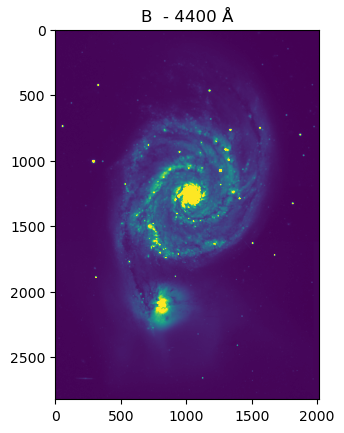

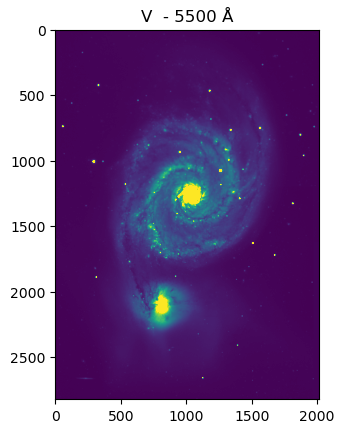

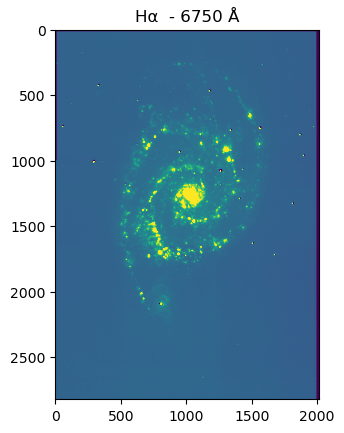

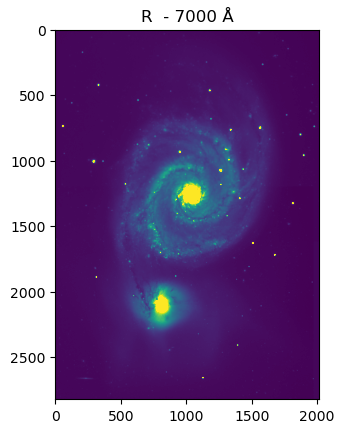

In [86]:
# First view the Images

# Images are not well balanced set 99% range
plt.figure()
vmin, vmax = np.percentile(M51_B, (0.5, 99.5))
plt.imshow(M51_B,vmin=vmin,vmax=vmax)
plt.title('B  - 4400 Å')

plt.figure()
vmin, vmax = np.percentile(M51_V, (0.5, 99.5))
plt.imshow(M51_V,vmin=vmin,vmax=vmax)
plt.title('V  - 5500 Å')

plt.figure()
vmin, vmax = np.percentile(M51_H_alpha, (0.5, 99.5))
plt.imshow(M51_H_alpha,vmin=vmin,vmax=vmax)
plt.title('H\u03B1  - 6750 Å')

plt.figure()
vmin, vmax = np.percentile(M51_R, (0.5, 99.5))
plt.imshow(M51_R,vmin=vmin,vmax=vmax)
plt.title('R  - 7000 Å')

In [87]:
# First mask out M51a

def remove_circle(image,x,y,rad):
    mask = np.empty_like(image)
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            if np.sqrt((i-x)**2 + (j-y)**2) < rad:
                mask[i,j] = 0
            else:
                mask[i,j] = 1
    return image*mask


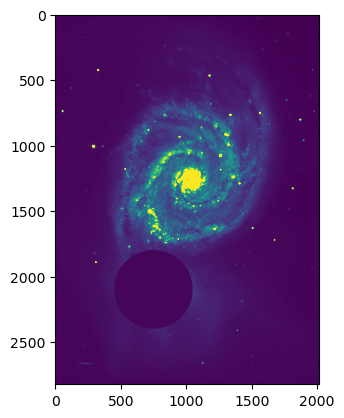

In [88]:
# B band

M_51_B_c = remove_circle(M51_B,2100,750,300)
vmin, vmax = np.percentile(M_51_B_c, (0.5, 99.5))
plt.imshow(M_51_B_c,vmin=vmin,vmax=vmax)

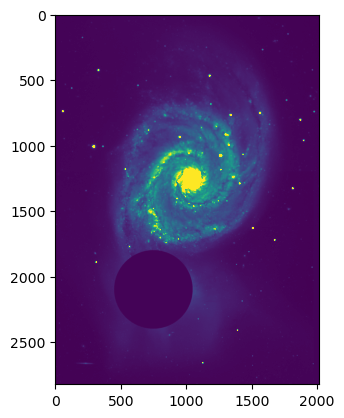

In [89]:
# V band

M_51_V_c = remove_circle(M51_V,2100,750,300)
vmin, vmax = np.percentile(M_51_V_c, (0.5, 99.5))
plt.imshow(M_51_V_c,vmin=vmin,vmax=vmax)

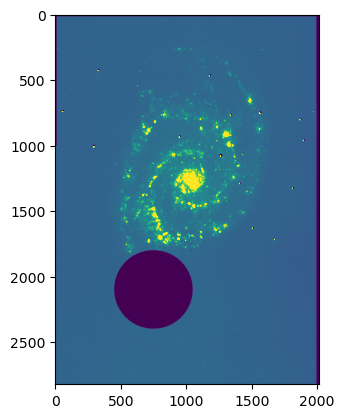

In [90]:
# H_alpha band

M_51_H_alpha_c = remove_circle(M51_H_alpha,2100,750,300)
vmin, vmax = np.percentile(M_51_H_alpha_c, (0.5, 99.5))
plt.imshow(M_51_H_alpha_c,vmin=vmin,vmax=vmax)

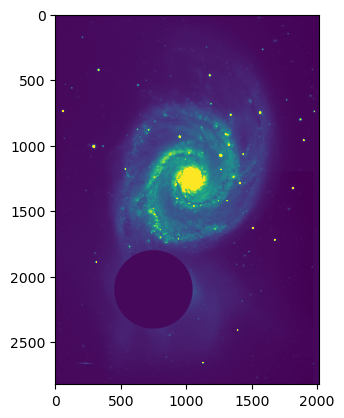

In [91]:
# R band

M_51_R_c = remove_circle(M51_R,2100,750,300)
vmin, vmax = np.percentile(M_51_R_c, (0.5, 99.5))
plt.imshow(M_51_R_c,vmin=vmin,vmax=vmax)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


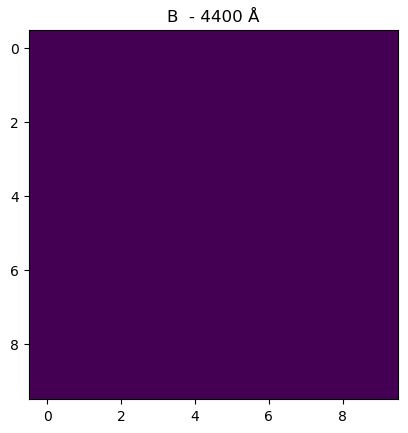

In [92]:
# Now need to estimate the backgrounds

# Take a sample of 10 pixels 

plt.figure()
plt.title('B  - 4400 Å')
plt.imshow(M_51_B_c[0:10,0:10])
print(M_51_B_c[0:10,0:10])



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


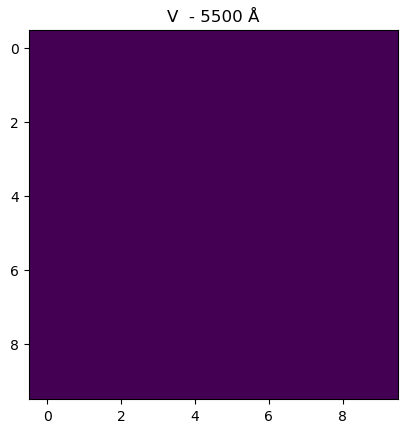

In [93]:
plt.figure()
plt.title('V  - 5500 Å')
plt.imshow(M_51_V_c[0:10,0:10])
print(M_51_V_c[0:10,0:10])


Background estimate:  0.11768112


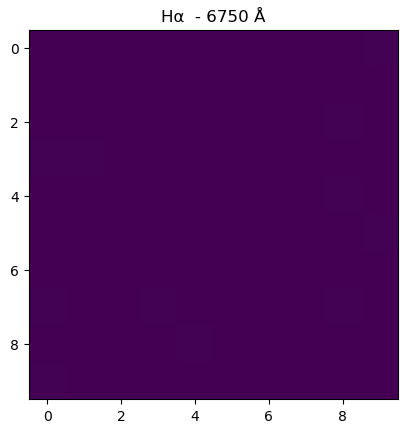

In [94]:

plt.figure()
plt.title('H\u03B1  - 6750 Å')
plt.imshow(M_51_H_alpha_c[20:30,20:30]-np.mean(M_51_H_alpha_c[20:30,20:30]),vmin=0,vmax = 1)
#print((M_51_H_alpha_c[20:30,20:30]- np.mean(M_51_H_alpha_c[20:30,20:30]),np.mean(M_51_H_alpha_c[20:30,20:30])))


# So can assume the background is:

print('Background estimate: ',np.mean(M_51_H_alpha_c[20:30,20:30]))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


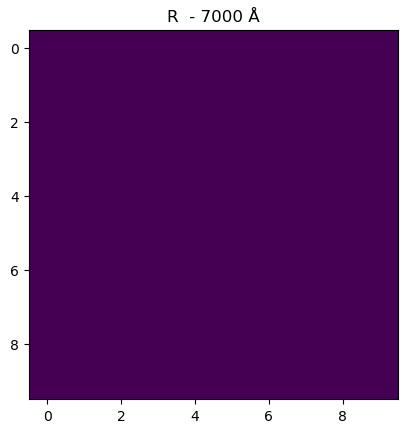

In [95]:
plt.figure()
plt.title('R  - 7000 Å')
plt.imshow(M_51_R_c[0:10,0:10])
print(M_51_R_c[0:10,0:10])

In [96]:
# Nice so all backgrounds are zero 

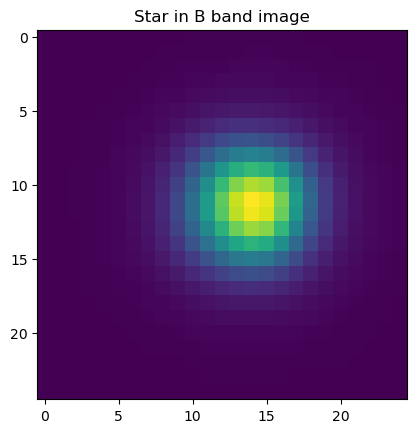

In [97]:
# Cannot find a good star/ comsic ray subtraction tool: will make my own

# Isolate a bit of an image that has one in and examine how they are different from the neighbourhood

plt.figure()
plt.title('Star in B band image')
plt.imshow(M_51_B_c[415:440,315:340])


In [98]:
star_centre = np.max(M_51_B_c[415:440,315:340])
star_centre, M_51_B_c[416,316]

(12.518354, 0.01563032)

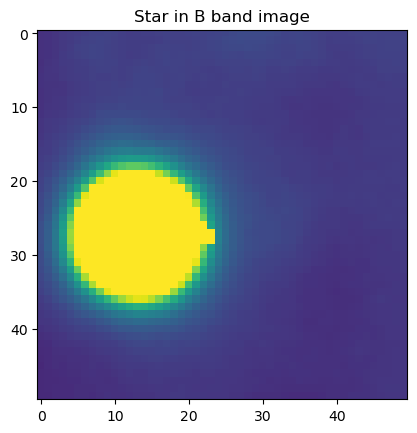

In [99]:
plt.figure()
plt.title('Star in B band image')
vmin, vmax = np.percentile(M_51_R_c[1000:1250,1250:1500], (0.5, 99.5))
plt.imshow(M_51_R_c[1050:1100,1250:1300],vmin=vmin,vmax=vmax)


In [100]:
star_centre = np.max(M_51_R_c[1050:1100,1250:1300])
star_centre, M_51_B_c[1050,1250]

(151.91011, 0.6754824)

In [101]:
import numpy as np
import pywt
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.convolution import interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel



# Define a function to remove wavelet coefficients that correspond to stars
def remove_stars(coeffs, threshold):
    clean_coeffs = []
    for level in range(len(coeffs)):
        level_coeffs = []
        for channel in range(len(coeffs[level])):
            channel_coeffs = coeffs[level][channel].copy()
            channel_coeffs[np.abs(channel_coeffs) > threshold] = 0.0
            level_coeffs.append(channel_coeffs)
        clean_coeffs.append(tuple(level_coeffs))
    return tuple(clean_coeffs)

# Define a function that replaces the stars
def subtract_stars(data, wavelet_level=3, threshold=10.0, replace_nan=True, kernel_width=10):
    # Pad the image with an extra row or column if necessary
    if data.shape[0] % 2 != 0:
        data = np.pad(data, ((0,1), (0,0)), mode='constant', constant_values=np.nan)
    if data.shape[1] % 2 != 0:
        data = np.pad(data, ((0,0), (0,1)), mode='constant', constant_values=np.nan)
    
    # Compute the wavelet transform of the image
    wavelet_coeffs = pywt.wavedec2(data, wavelet='db4', level=wavelet_level)

    # Remove the stars from the wavelet coefficients
    clean_coeffs = remove_stars(wavelet_coeffs, (np.mean(data) + threshold*np.std(data)))

    # Reconstruct the image from the cleaned wavelet coefficients
    subtracted_image = pywt.waverec2(clean_coeffs, wavelet='db4')

    # Remove the padding
    subtracted_image = subtracted_image[:data.shape[0], :data.shape[1]]

    if replace_nan:
        # Replace the removed pixels with NaN values
        removed_pixels = data - subtracted_image
        subtracted_image[removed_pixels != 0] = np.nan

        # Interpolate the NaN values using astropy's interpolate_replace_nans function
        gaussian_kernel = Gaussian2DKernel(kernel_width)
        subtracted_image = interpolate_replace_nans(subtracted_image, gaussian_kernel)

    return subtracted_image




In [102]:
sub_image = subtract_stars(M_51_R_c,threshold=5.0)

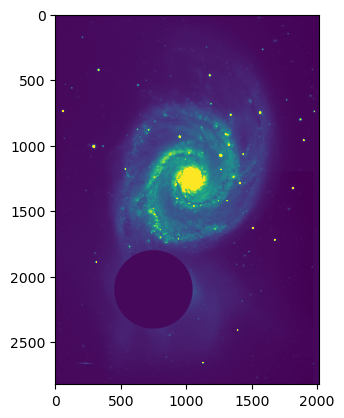

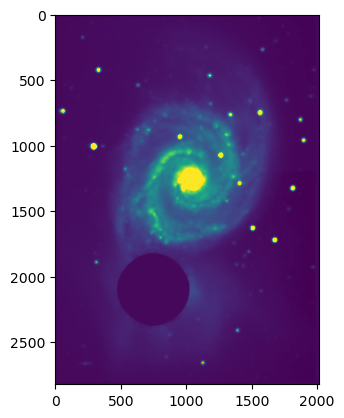

In [103]:
plt.figure()
vmin, vmax = np.percentile(M_51_R_c, (0.5, 99.5))
plt.imshow(M_51_R_c,vmin=vmin,vmax=vmax)

bulge_intensity = np.nanmax(M_51_R_c)
bulge_pos = np.asarray(np.argwhere(M_51_R_c == bulge_intensity))
plt.plot()

plt.figure()
plt.imshow(sub_image,vmin=vmin,vmax=vmax)

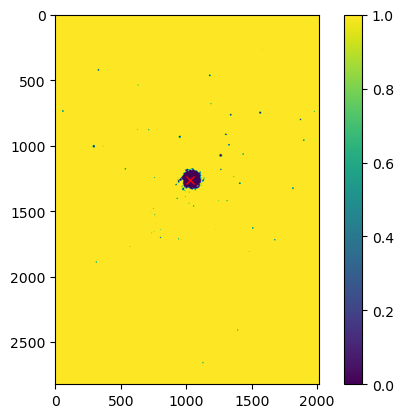

In [104]:
# This method is not working instead use thresholding and interpolation

thresh_mask = gfits.threshold_image(M_51_R_c,np.mean(M_51_R_c)+4*np.std(M_51_R_c))

plt.imshow(thresh_mask) # This is good but we don't want to absorb the bulge
# Solution exclude the centre
plt.plot((M_51_R_c.shape[1]/2)+20,(M_51_R_c.shape[0]/2)-150,'rx')
plt.colorbar()

(1261, 1026)


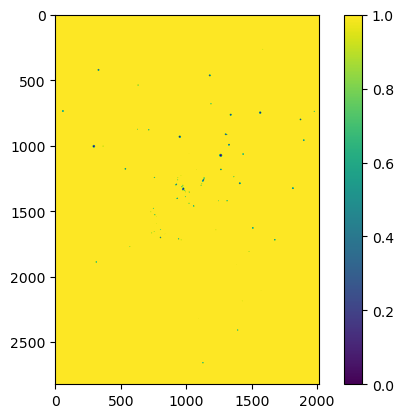

In [105]:
from skimage.segmentation import flood, flood_fill

bulge_loc = (int((M_51_R_c.shape[0]/2)-150),int((M_51_R_c.shape[1]/2)+20))
print(bulge_loc)
thresh_mask_no_bulge = flood_fill(thresh_mask,bulge_loc,1)
plt.imshow(thresh_mask_no_bulge)
plt.colorbar()

thresh_mask_no_bulge = thresh_mask_no_bulge.astype(float)

In [106]:
# Convert zeros in mask to nans
thresh_mask_no_bulge[thresh_mask_no_bulge == 0] = np.nan

# Apply mask to image and interpolate
stars_naned = M_51_B_c*thresh_mask_no_bulge

# Interpolate the NaN values using astropy's interpolate_replace_nans function
gaussian_kernel = Gaussian2DKernel(10)
stars_removed = interpolate_replace_nans(stars_naned, gaussian_kernel)



Text(0.5, 1.0, 'Star Subtracted R  - 7000 Å')

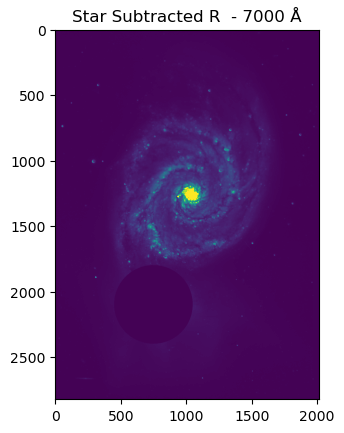

In [107]:
vmin, vmax = np.percentile(stars_removed, (0.5, 99.9))
plt.imshow(stars_removed,vmin=vmin,vmax=vmax)
plt.title('Star Subtracted R  - 7000 Å')

In [108]:
# Make this into a function

def Subtract_Stars(image,bulge_pos,N_sigma=4,Nan_kernel_width=10):
    
    # Assume stars are all beyond 99% of the intensity
    thresh_mask = gfits.threshold_image(image,np.mean(image)+N_sigma*np.std(image))
    
    # Fill the bulge to remove from mask
    thresh_mask_no_bulge = flood_fill(thresh_mask,bulge_pos,1) #  Remember bulge_loc is (y,x)
    
    # Convert zeros in mask to nans
    thresh_mask_no_bulge[thresh_mask_no_bulge == 0] = np.nan

    # Apply mask to image and interpolate
    stars_naned = image*thresh_mask_no_bulge

    # Interpolate the NaN values using astropy's interpolate_replace_nans function
    gaussian_kernel = Gaussian2DKernel(Nan_kernel_width)
    stars_removed = interpolate_replace_nans(stars_naned, gaussian_kernel)
    
    return stars_removed
        
        
    
    

In [109]:
M_51_B_clean = Subtract_Stars(M_51_B_c,bulge_loc)

Text(0.5, 1.0, 'B - band - star subtracted')

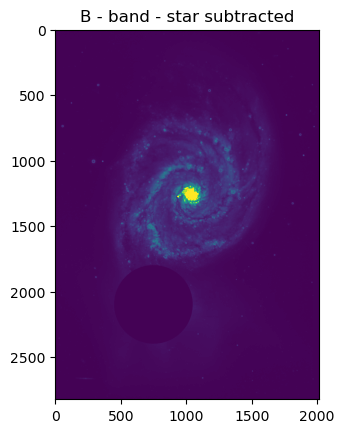

In [110]:
vmin, vmax = np.percentile(M_51_B_clean, (0.5, 99.9))
plt.imshow(M_51_B_clean,vmin=vmin,vmax=vmax)
plt.title('B - band - star subtracted')

In [111]:
M_51_V_clean = Subtract_Stars(M_51_V_c,(1247,1037))

Text(0.5, 1.0, 'V band - star subtracted')

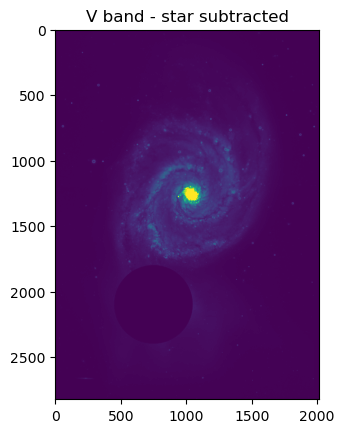

In [112]:
vmin, vmax = np.percentile(M_51_V_clean, (0.5, 99.9))
plt.imshow(M_51_V_clean,vmin=vmin,vmax=vmax)
plt.title('V band - star subtracted')

In [113]:
M_51_H_alpha_clean = Subtract_Stars(M_51_H_alpha_c,(1247,1037))

Text(0.5, 1.0, 'Hα band - star subtracted')

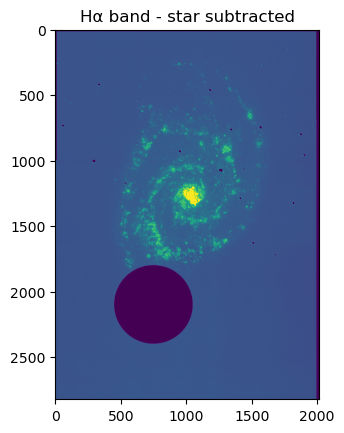

In [114]:
vmin, vmax = np.percentile(M_51_H_alpha_clean, (0.5, 99.9))
plt.imshow(M_51_H_alpha_clean,vmin=vmin,vmax=vmax)
plt.title('H\u03B1 band - star subtracted')

In [115]:
M_51_R_clean = Subtract_Stars(M_51_R_c,(1247,1037))

Text(0.5, 1.0, 'R band - star subtracted')

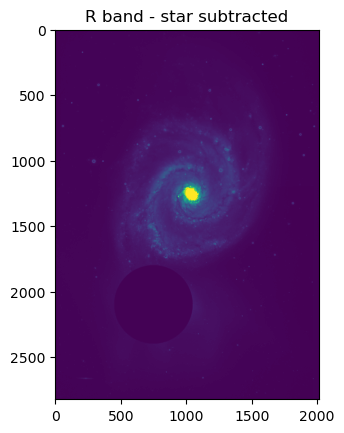

In [116]:
vmin, vmax = np.percentile(M_51_R_clean, (0.5, 99.9))
plt.imshow(M_51_R_clean,vmin=vmin,vmax=vmax)
plt.title('R band - star subtracted')

In [117]:
# Export the Star Subtracted images

# Add the background for FICL processing

M_51_B_clean += 1000
M_51_V_clean += 1000
M_51_H_alpha_clean += 1000
M_51_R_clean += 1000


dataB, header_B = fits.getdata('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_B_kab2003.fits', header=True)

dataV, header_V = fits.getdata('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_V_kab2003.fits', header=True)

dataHa, header_Ha = fits.getdata('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_Ha_sub_kab2003.fits', header=True)

dataR, header_R = fits.getdata('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_R_kab2003.fits', header=True)

# Un-comment for write

#fits.writeto('M_51_B_KPNO.fits', M_51_B_clean, header_B, overwrite=True)
#fits.writeto('M_51_V_KPNO.fits', M_51_V_clean, header_V, overwrite=True)
#fits.writeto('M_51_Ha_KPNO.fits', M_51_H_alpha_clean, header_Ha, overwrite=True)
#fits.writeto('M_51_R_KPNO.fits', M_51_R_clean, header_R, overwrite=True)

In [118]:
# Inspect Isolated Images and tables

M51_B_I = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_B_KPNO/0200/small_nonpar.fits')
M51_B_Table = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_B_KPNO/0200/source_params.fits')


M51_R_I = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_R_KPNO/0200/small_nonpar.fits')
M51_R_Table = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_R_KPNO/0200/source_params.fits')


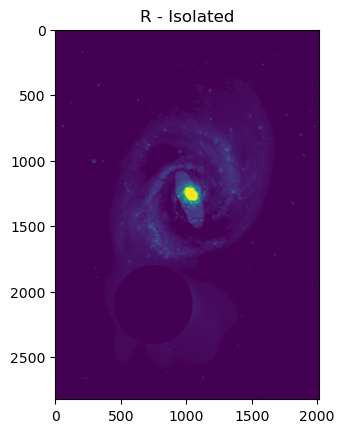

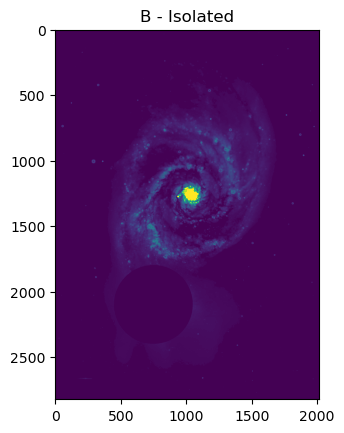

In [119]:
plt.figure()
vmin, vmax = np.percentile(M51_R_I, (0.5, 99.9))
plt.title('R - Isolated')
plt.imshow(M51_R_I,vmin=vmin, vmax=vmax)

plt.figure()
vmin, vmax = np.percentile(M51_B_I, (0.5, 99.9))
plt.title('B - Isolated')
plt.imshow(M51_B_I,vmin=vmin, vmax=vmax)

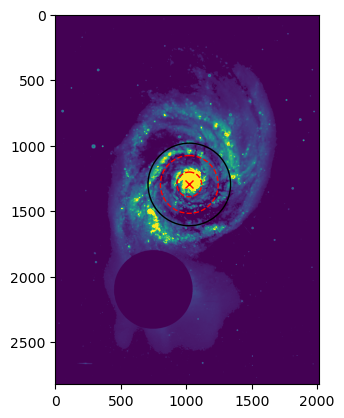

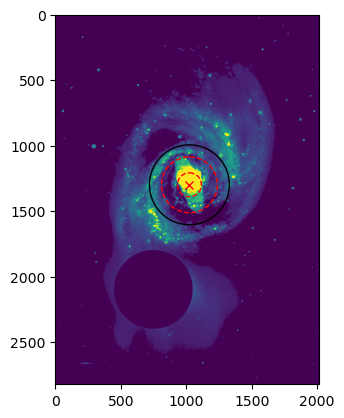

In [120]:
gfits.Overlay_table_info(M51_B_I,M51_B_Table,0.3,0.7)
gfits.Overlay_table_info(M51_R_I,M51_R_Table,0.3,0.7) # These look shit

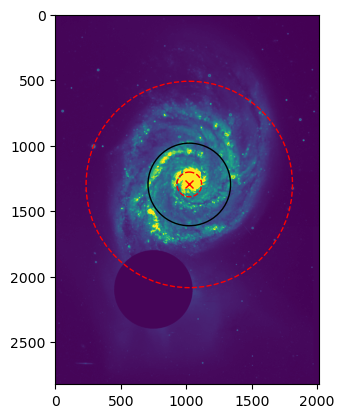

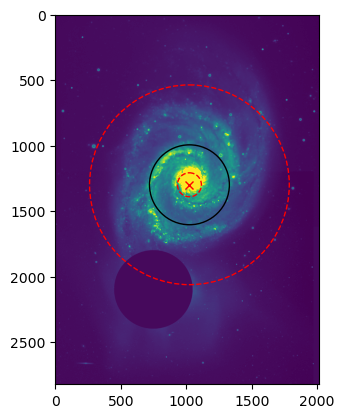

In [121]:
gfits.Overlay_table_info(M_51_B_clean,M51_B_Table,0.3,2.5)
gfits.Overlay_table_info(M_51_R_clean,M51_R_Table,0.3,2.5)

[[1258 1036]]
None


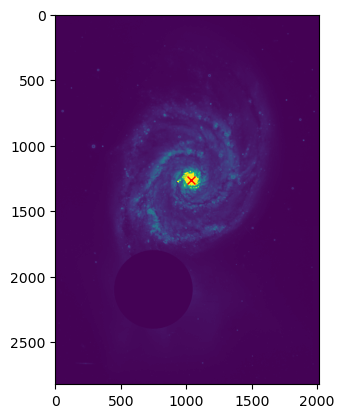

In [122]:
# Modify Table for centre
def max_intensity_pos(image,relative=False):
    bulge_intensity = np.nanmax(image)
    bulge_pos = np.asarray(np.argwhere(image == bulge_intensity))
    if relative:
        bulge_pos[0,0] = bulge_pos[0,0] - image.shape[0]/2
        bulge_pos[0,1] = bulge_pos[0,1] - image.shape[1]/2
    else:
        return bulge_pos

pos = max_intensity_pos(M_51_B_clean)

pos_rel = max_intensity_pos(M_51_B_clean,relative=True)
vmin, vmax = np.percentile(M_51_B_clean, (0.5, 99.9))
plt.imshow(M_51_B_clean,vmin=vmin,vmax=vmax)
plt.plot(pos[0,1],pos[0,0],'rx')
print(pos)
#print(pos[0,1] - M_51_B_clean.shape[1]/2,pos[0,0] - M_51_B_clean.shape[0]/2)
print(pos_rel)



In [123]:
from astropy.wcs import WCS
# Develop outside of a function

hdul = fits.open('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_B_KPNO.fits')

image = M_51_B_clean

fits_info = {}  # Create dictionary for header info
for key, value in hdul[0].header.items():
    fits_info[key] = value

# Retreive Pixel scale conversion factors
X_deg = fits_info['CD1_1'] 
Y_deg = fits_info['CD2_2'] 

# Reference coord and corresponding pixel
RA_ref_coord  = fits_info['CRVAL1'] 
DEC_ref_coord = fits_info['CRVAL2'] 

RA_ref_pix  = fits_info['CRPIX1'] 
DEC_ref_pix = fits_info['CRPIX2'] 

# Calculate Image pixel coords through WCS
wcs = WCS(hdul[0].header)

# Create arrays to store the RA and Dec coordinates
RA = np.empty(image.shape)
DEC = np.empty(image.shape)

# Loop over all pixel coordinates and convert to RA and Dec
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        ra, dec = wcs.all_pix2world(j, i, 0)
        RA[i,j] = ra
        DEC[i,j] = dec





In [124]:
# Now set N ticks and sample from these
N_ticks = 5
RA_sample_mask = np.linspace(0,(RA[0,:].shape[0]-1),N_ticks).astype(int)
DEC_sample_mask = np.linspace(0,(DEC[:,0].shape[0]-1),N_ticks).astype(int)
RA_arr  = RA[0,:]
DEC_arr = DEC[:,0]

RA_ticks  = RA_arr[RA_sample_mask]
DEC_ticks = DEC_arr[DEC_sample_mask]

RA_ticks, DEC_ticks


(array([202.59871897, 202.53612956, 202.47354   , 202.41095044,
        202.34836103]),
 array([47.08851031, 47.14823917, 47.20796816, 47.26769715, 47.32751073]))

Text(0, 0.5, 'DEC (Deg)')

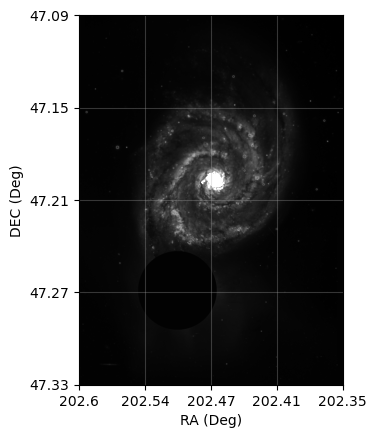

In [125]:
plt.figure()
vmin, vmax = np.percentile(image, (0.2, 99.8))
plt.imshow(image,cmap='gray',vmin=vmin,vmax=vmax)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')


Text(0, 0.5, 'DEC (Deg)')

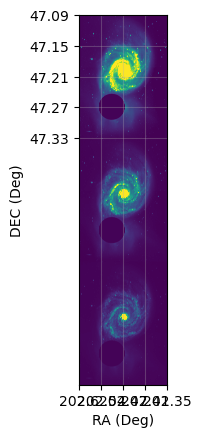

In [126]:
RGB_image = np.vstack([M_51_R_clean,M_51_V_clean,M_51_B_clean])

plt.figure()
vmin, vmax = np.percentile(image, (0.2, 99.8))
plt.imshow(RGB_image,vmin=vmin,vmax=vmax)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))

plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')


(1, 1) [1023]
(1, 1) [1023]
Winding angle φ = -84.2894068624902  Pattern position angle θ =  -16.239904827898417


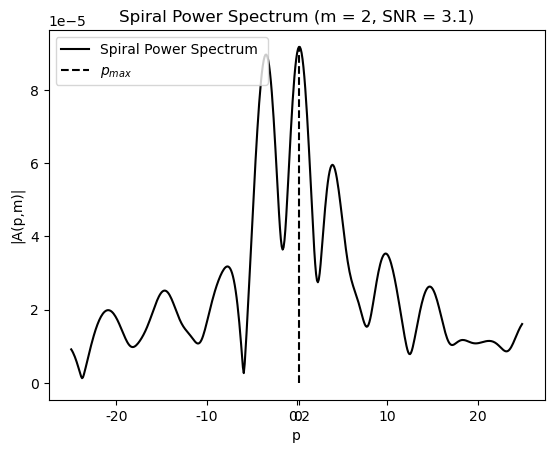

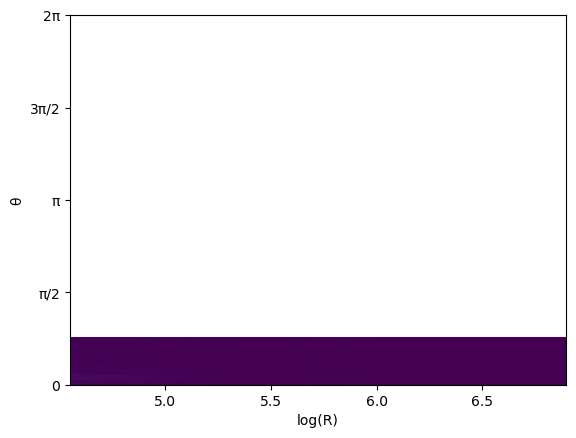

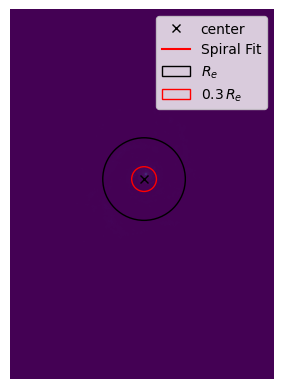

In [127]:
# Run SFT on image
phi, theta = gfits.Spiral_Fourier_Transform(image,M51_B_Table,0.3,2,True,False)

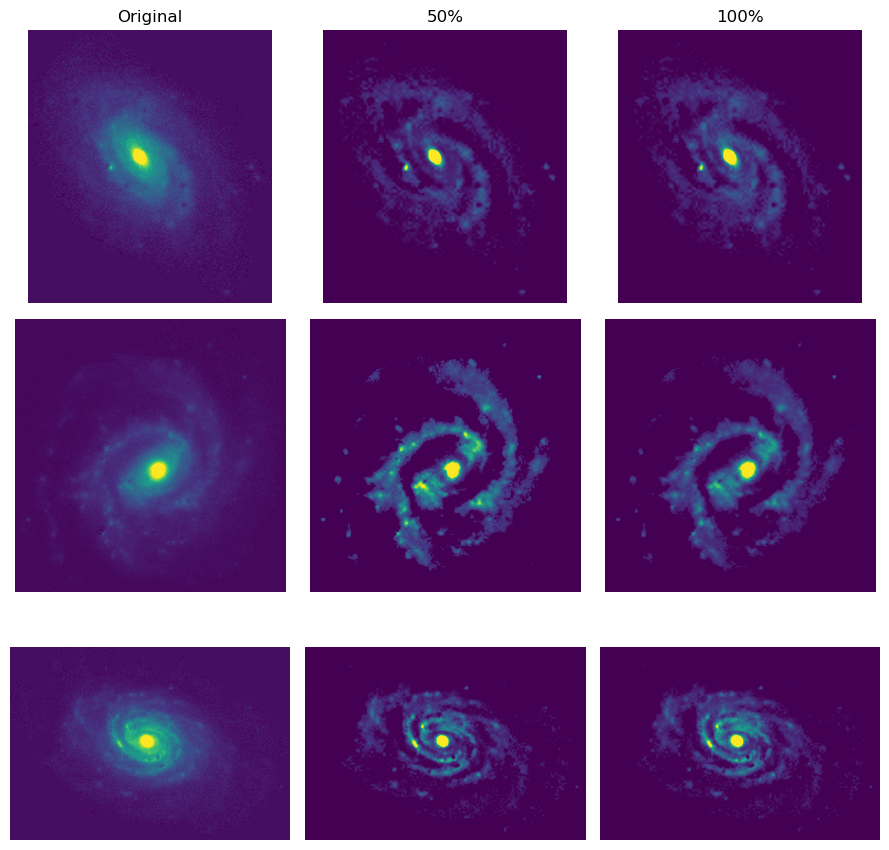

In [128]:
# Demonstration of the non parametric extraction

# Import good spiral candidates:
name1 = '587731522282258436'
Org1     = gfits.Read('/home/borge/Data/587731522282258436ra.fits.gz')
ISO50_1  = gfits.Read('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587731522282258436ra/0100/small_nonpar.fits')
ISO100_1 = gfits.Read('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587731522282258436ra/0200/small_nonpar.fits')

name2 = '587731892188545037'
Org2     = gfits.Read('/home/borge/Data/Test_batch/587731892188545037ra.fits.gz')
ISO50_2  = gfits.Read('/home/borge/Data/Output_Data/Distributed_run/587731892188545037ra/0100/small_nonpar.fits')
ISO100_2 = gfits.Read('/home/borge/Data/Output_Data/Distributed_run/587731892188545037ra/0200/small_nonpar.fits')

name3 = '588848900983357543'
Org3     = gfits.Read('/home/borge/Data/588848900983357543ra.fits.gz')
ISO50_3  = gfits.Read('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/588848900983357543ra/0100/small_nonpar.fits')
ISO100_3 = gfits.Read('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/588848900983357543ra/0200/small_nonpar.fits')

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(9, 9)

# Row 1
#==================================================

vmin, vmax = np.percentile(Org1, (0.2, 99.8))
axs[0,0].imshow(Org1,vmin=vmin,vmax=vmax)
axs[0,0].axis('off')
axs[0,0].set_title('Original')

vmin, vmax = np.percentile(ISO50_1, (0.2, 99.8))
axs[0,1].imshow(ISO50_1,vmin=vmin,vmax=vmax)
axs[0,1].axis('off')
axs[0,1].set_title('50%')

vmin, vmax = np.percentile(ISO100_1, (0.2, 99.8))
axs[0,2].imshow(ISO100_1,vmin=vmin,vmax=vmax)
axs[0,2].axis('off')
axs[0,2].set_title('100%')

# Row 2
#==================================================

vmin, vmax = np.percentile(Org2, (0.2, 99.8))
axs[1,0].imshow(Org2,vmin=vmin,vmax=vmax)
axs[1,0].axis('off')

vmin, vmax = np.percentile(ISO50_2, (0.2, 99.8))
axs[1,1].imshow(ISO50_2,vmin=vmin,vmax=vmax)
axs[1,1].axis('off')

vmin, vmax = np.percentile(ISO100_2, (0.2, 99.8))
axs[1,2].imshow(ISO100_2,vmin=vmin,vmax=vmax)
axs[1,2].axis('off')

# Row 3
#==================================================

vmin, vmax = np.percentile(Org3, (0.2, 99.8))
axs[2,0].imshow(Org3,vmin=vmin,vmax=vmax)
axs[2,0].axis('off')

vmin, vmax = np.percentile(ISO50_3, (0.2, 99.8))
axs[2,1].imshow(ISO50_3,vmin=vmin,vmax=vmax)
axs[2,1].axis('off')

vmin, vmax = np.percentile(ISO100_3, (0.2, 99.8))
axs[2,2].imshow(ISO100_3,vmin=vmin,vmax=vmax)
axs[2,2].axis('off')

# Plotting
#==================================================

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
fig.tight_layout()
plt.show()

In [129]:
# Function to trim images to a specified width
def trim_image(image, target_width):
    height, width = image.shape
    left = (width - target_width) // 2
    right = left + target_width
    return image[:, left:right]

# Trim images to have the same width
target_width = int(min([Org1.shape[1], ISO50_2.shape[1], ISO100_3.shape[1]]))

Org1 = trim_image(Org1, target_width)
ISO50_1 = trim_image(ISO50_1, target_width)
ISO100_1 = trim_image(ISO100_1, target_width)
Org2 = trim_image(Org2, target_width)
ISO50_2 = trim_image(ISO50_2, target_width)
ISO100_2 = trim_image(ISO100_2, target_width)
Org3 = trim_image(Org3, target_width)
ISO50_3 = trim_image(ISO50_3, target_width)
ISO100_3 = trim_image(ISO100_3, target_width)

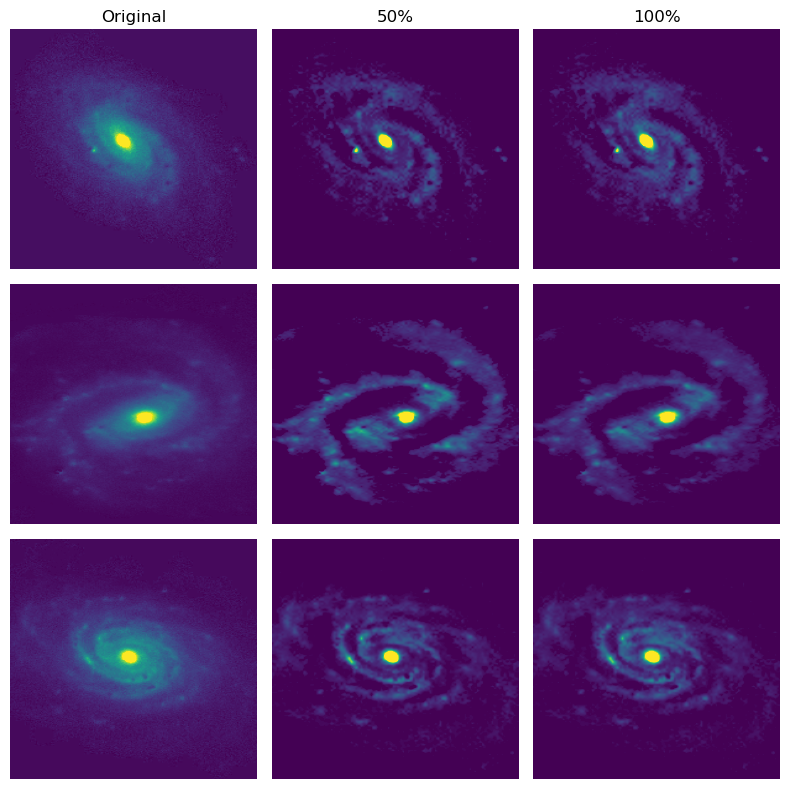

Names:  587731522282258436 587731892188545037 588848900983357543


In [130]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Demonstration of the non-parametric extraction


fig = plt.figure(figsize=(8, 8))
gs = GridSpec(3, 3)

# Add subplots to the GridSpec
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 2]),
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[2, 2])
]

# Row 1
# ==================================================

vmin, vmax = np.percentile(Org1, (0.2, 99.8))
axs[0].imshow(Org1, vmin=vmin, vmax=vmax,aspect='auto')
axs[0].axis('off')
axs[0].set_title('Original')

vmin, vmax = np.percentile(ISO50_1, (0.2, 99.8))
axs[1].imshow(ISO50_1, vmin=vmin, vmax=vmax,aspect='auto')
axs[1].axis('off')
axs[1].set_title('50%')

vmin, vmax = np.percentile(ISO100_1, (0.2, 99.8))
axs[2].imshow(ISO100_1, vmin=vmin, vmax=vmax,aspect='auto')
axs[2].axis('off')
axs[2].set_title('100%')

# Row 2
# ==================================================

vmin, vmax = np.percentile(Org2, (0.2, 99.8))
axs[3].imshow(Org2, vmin=vmin, vmax=vmax,aspect='auto')
axs[3].axis('off')

vmin, vmax = np.percentile(ISO50_2, (0.2, 99.8))
axs[4].imshow(ISO50_2, vmin=vmin, vmax=vmax,aspect='auto')
axs[4].axis('off')

vmin, vmax = np.percentile(ISO100_2, (0.2, 99.8))
axs[5].imshow(ISO100_2, vmin=vmin, vmax=vmax,aspect='auto')
axs[5].axis('off')

# Row 3
#==================================================
vmin, vmax = np.percentile(Org3, (0.2, 99.8))
axs[6].imshow(Org3, vmin=vmin, vmax=vmax,aspect='auto')
axs[6].axis('off')

vmin, vmax = np.percentile(ISO50_3, (0.2, 99.8))
axs[7].imshow(ISO50_3, vmin=vmin, vmax=vmax,aspect='auto')
axs[7].axis('off')

vmin, vmax = np.percentile(ISO100_3, (0.2, 99.8))
axs[8].imshow(ISO100_3, vmin=vmin, vmax=vmax,aspect='auto')
axs[8].axis('off')

# Plotting
#==================================================
plt.tight_layout()
plt.show()

print('Names: ',name1,name2,name3)

In [131]:
GZ2 = gfits.Read_Table('/home/borge/Data/gz2and1master.fits.gz')
table1 = gfits.cat_search(GZ2,name1)
table2 = gfits.cat_search(GZ2,name2)
table3 = gfits.cat_search(GZ2,name3)
table1,table2,table3

(<Table length=1>
       OBJID             OBJID_STR       ... arms_clean_union
       int64               str20         ...       bool      
 ------------------ -------------------- ... ----------------
 587731522282258436 587731522282258436   ...             True,
 <Table length=1>
       OBJID             OBJID_STR       ... arms_clean_union
       int64               str20         ...       bool      
 ------------------ -------------------- ... ----------------
 587731892188545037 587731892188545037   ...             True,
 <Table length=1>
       OBJID             OBJID_STR       ... arms_clean_union
       int64               str20         ...       bool      
 ------------------ -------------------- ... ----------------
 588848900983357543 588848900983357543   ...             True)

In [132]:
RA1  = table1['RA'] 
DEC1 = table1['DEC'] 

RA2  = table2['RA'] 
DEC2 = table2['DEC']

RA3  = table3['RA'] 
DEC3 = table3['DEC']

print(RA1,DEC1,'\n',RA2,DEC2,'\n',RA3,DEC3)

        RA       
-----------------
139.5591583251953        DEC       
-----------------
45.65169143676758 
         RA        
------------------
178.74465942382812        DEC       
-----------------
58.49361038208008 
         RA       
-----------------
173.0560760498047        DEC       
-----------------
0.819283664226532


: 